In [30]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx
import argparse
import pickle

import graph_tool.all as gt
from graph_tool.all import *
from graph_creation import *
from motif_counts import *

In [31]:
syn_table = pd.read_csv('/Users/rweberla/Downloads/connections_no_threshold.csv')
syn_table

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940623828999,720575940612348950,SLP_R,4,GLUT
2,720575940624078484,720575940616950161,SMP_R,2,ACH
3,720575940629583345,720575940620324735,SMP_L,2,GLUT
4,720575940605876866,720575940606514878,LAL_R,15,GABA
...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,ACH
16847993,720575940624016823,720575940622760993,ME_R,4,ACH
16847994,720575940637397309,720575940633255123,SLP_R,2,GABA
16847995,720575940636432014,720575940617470681,ME_R,1,GLUT


In [35]:
# build index dictionary
cellids =  np.unique(syn_table[["pre_root_id", "post_root_id"]])
nid2cid = {i: cid for i, cid in enumerate(cellids)}
cid2nid = {cid: i for i, cid in enumerate(cellids)}

In [36]:
syn_table["pre_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["pre_root_id"]], 
		index=syn_table.index)
syn_table["post_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["post_root_id"]], 
		index=syn_table.index)

In [201]:
syn_table

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,pre_nid,post_nid
0,720575940629970489,720575940631267655,AVLP_R,7,GABA,96274,103137
1,720575940623828999,720575940612348950,SLP_R,4,GLUT,62790,13822
2,720575940624078484,720575940616950161,SMP_R,2,ACH,64248,29086
3,720575940629583345,720575940620324735,SMP_L,2,GLUT,94318,42941
4,720575940605876866,720575940606514878,LAL_R,15,GABA,2405,3347
...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,ACH,24961,57182
16847993,720575940624016823,720575940622760993,ME_R,4,ACH,63889,56848
16847994,720575940637397309,720575940633255123,SLP_R,2,GABA,122411,111854
16847995,720575940636432014,720575940617470681,ME_R,1,GLUT,120280,30981


In [202]:
edge_list = [(e[0], e[1], e[2], e[3], e[4]) for e in syn_table[["pre_nid", "post_nid", "neuropil", "syn_count", "nt_type"]].values]

In [203]:
edge_list[0]

(96274, 103137, 'AVLP_R', 7, 'GABA')

In [204]:
merged_syn_table = syn_table[["pre_nid", "post_nid", "syn_count", 'nt_type']].groupby(by=["pre_nid", "post_nid"]).sum().reset_index()

In [41]:
merged_edge_list = [(e[0], e[1], e[2]) for e in merged_syn_table.values]

In [206]:
merged_edge_list[:4]

[(0, 52, 2), (0, 118, 11), (0, 165, 1), (0, 207, 18)]

In [43]:
cellids[:50]

array([720575940596125868, 720575940597856265, 720575940597944841,
       720575940598267657, 720575940599333574, 720575940599457990,
       720575940599459782, 720575940599704006, 720575940599729862,
       720575940599733446, 720575940599736492, 720575940599744172,
       720575940599755718, 720575940599763910, 720575940599797164,
       720575940600010668, 720575940600071689, 720575940600084489,
       720575940600101641, 720575940600124169, 720575940600143369,
       720575940600150793, 720575940600322965, 720575940600433181,
       720575940600547529, 720575940600588204, 720575940600623020,
       720575940600646173, 720575940600722348, 720575940600782252,
       720575940600850441, 720575940600866569, 720575940600934665,
       720575940601049097, 720575940601067436, 720575940601103625,
       720575940601206499, 720575940601263473, 720575940601325484,
       720575940601412361, 720575940601423625, 720575940601598892,
       720575940601603185, 720575940601653513, 720575940601672

In [207]:
g = gt.Graph()
g.add_vertex(len(cellids))
e_syn_count = g.new_ep("int32_t")
e_nt_type = g.new_ep("int32_t")
g.add_edge_list(merged_edge_list, eprops=[e_syn_count, e_nt_type])
g.vp["cellid"] = g.new_vp("int64_t")
g.vp["cellid"].a = cellids
g.ep["syn_count"] = e_syn_count
g.ep["nt_type"] = e_nt_type

In [27]:
e_syn_count

<EdgePropertyMap object with value type 'int32_t', for Graph 0x5db447050, at 0x5d8f3be90>

In [18]:
# get neuropil subgraph
np_motif_profiles = {}
np_cfg_motif_profiles = {}
neuropil_name = 'whole'

u = gt.Graph(g, prune=True)
g.clear_filters()

np_motif_profiles[neuropil_name] = gt.motifs(u, k=3, p=1.0, motif_list=None, return_maps=False)

In [19]:
np_motif_profiles

{'whole': ([<Graph object, directed, with 3 vertices and 2 edges, at 0x17f0f2a80>],
  [1225])}

In [21]:
g

<Graph object, directed, with 138639 vertices and 50 edges, 1 internal vertex property, 1 internal edge property, at 0x5d8f304d0>

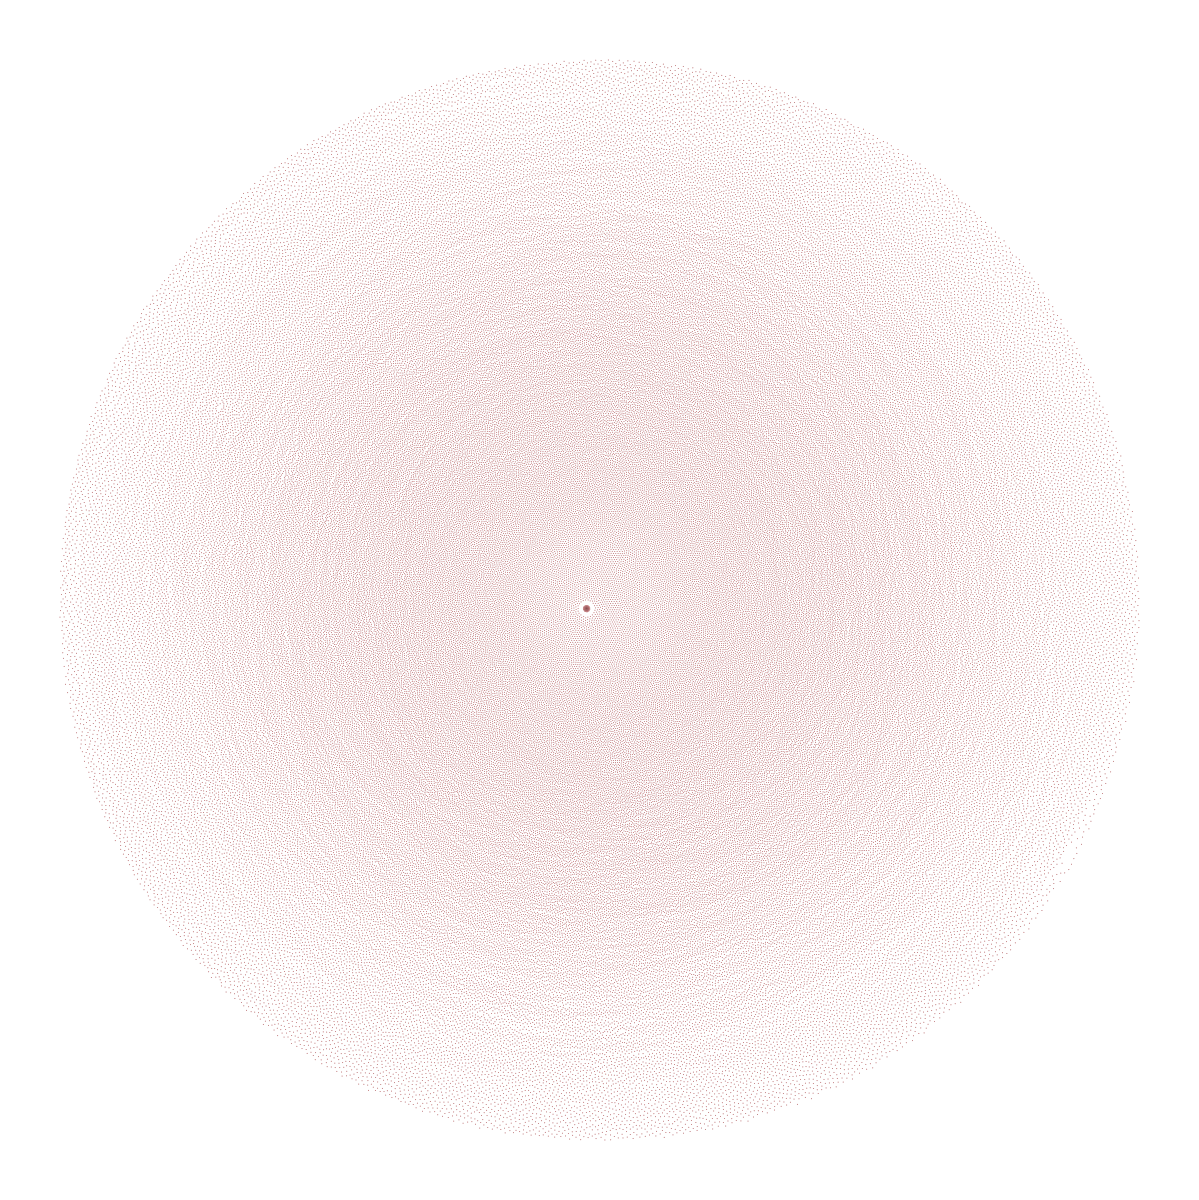

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x5d8f304d0, at 0x5bf893320>

In [20]:
graph_draw(g)

In [208]:
# Define the size of the test group
test_group_size = 1000

# Filter the syn_table to include only the first test_group_size unique cell IDs
unique_pre_ids = syn_table["pre_root_id"].unique()[:test_group_size]
unique_post_ids = syn_table["post_root_id"].unique()[:test_group_size]
filtered_syn_table = syn_table[syn_table["pre_root_id"].isin(unique_pre_ids) & syn_table["post_root_id"].isin(unique_post_ids)]

# Build index dictionary for the filtered data
cellids = np.unique(filtered_syn_table[["pre_root_id", "post_root_id"]])
nid2cid = {i: cid for i, cid in enumerate(cellids)}
cid2nid = {cid: i for i, cid in enumerate(cellids)}

filtered_syn_table["pre_nid"] = pd.Series([cid2nid[cid] for cid in filtered_syn_table["pre_root_id"]],
                                          index=filtered_syn_table.index)
filtered_syn_table["post_nid"] = pd.Series([cid2nid[cid] for cid in filtered_syn_table["post_root_id"]],
                                           index=filtered_syn_table.index)

edge_list = [(e[0], e[1], e[2], e[3], e[4]) for e in
             filtered_syn_table[["pre_nid", "post_nid", "neuropil", "syn_count", "nt_type"]].values]

merged_syn_table = filtered_syn_table[["pre_nid", "post_nid", "syn_count", 'nt_type']
                                     ].groupby(by=["pre_nid", "post_nid"]).sum().reset_index()

merged_edge_list = [(e[0], e[1], e[2]) for e in merged_syn_table.values]

g = gt.Graph()
g.add_vertex(len(cellids))
e_syn_count = g.new_ep("int32_t")
e_nt_type = g.new_ep("int32_t")
g.add_edge_list(merged_edge_list, eprops=[e_syn_count, e_nt_type])
g.vp["cellid"] = g.new_vp("int64_t")
g.vp["cellid"].a = cellids
g.ep["syn_count"] = e_syn_count
g.ep["nt_type"] = e_nt_type

# Print the graph to verify
print("Number of vertices in test graph:", g.num_vertices())
print("Number of edges in test graph:", g.num_edges())

/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_75039/3726411367.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_syn_table["pre_nid"] = pd.Series([cid2nid[cid] for cid in filtered_syn_table["pre_root_id"]],
/var/folders/db/q8_kwk2x73df8d997nrf14k1nfx1_b/T/ipykernel_75039/3726411367.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_syn_table["post_nid"] = pd.Series([cid2nid[cid] for cid in filtered_syn_table["post_root_id"]],


Number of vertices in test graph: 1861
Number of edges in test graph: 25877


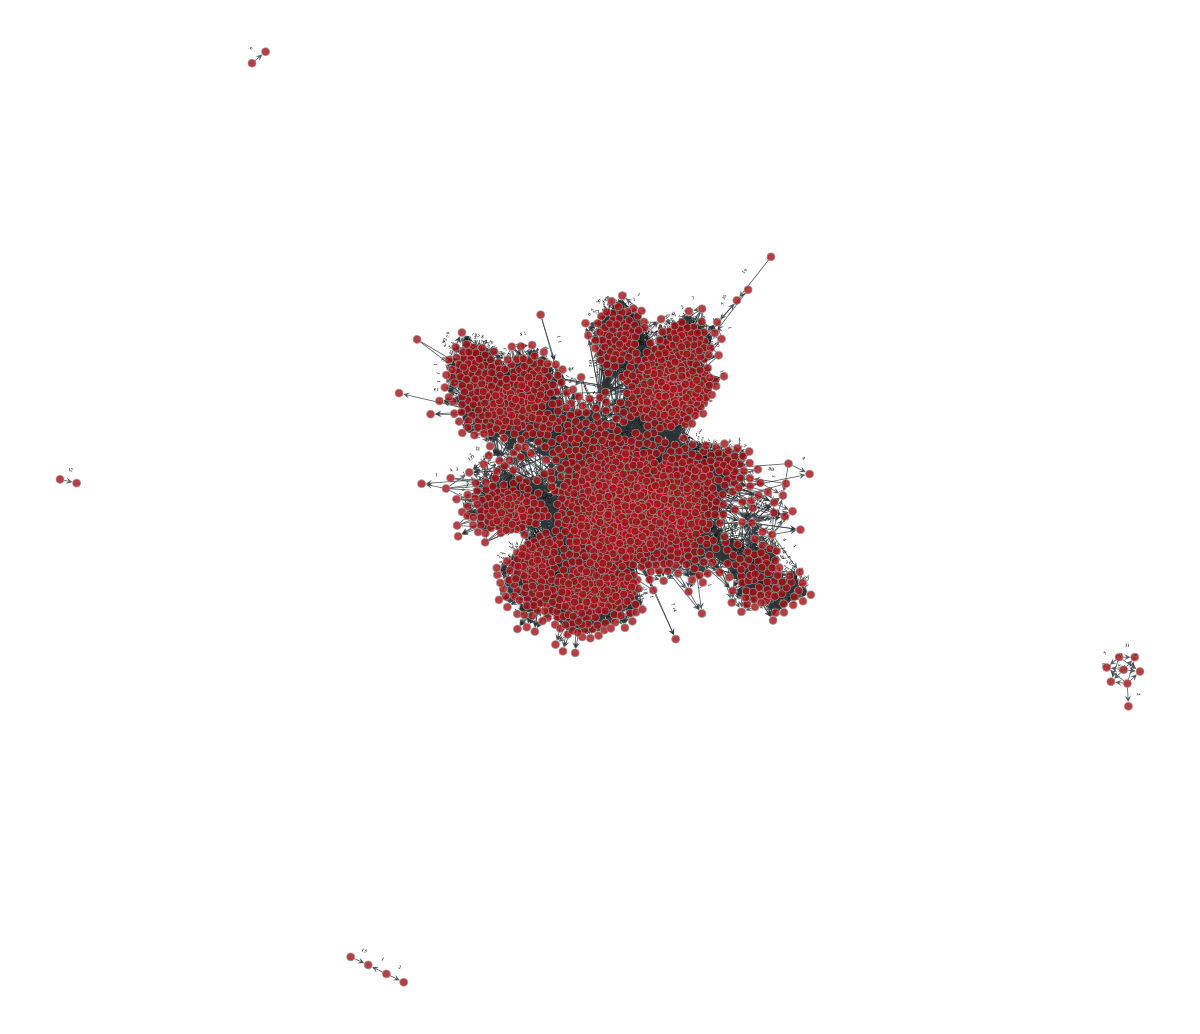

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x427ee98b0, at 0x369bb7f80>

In [185]:
graph_draw(g, edge_text=g.ep["syn_count"])

In [186]:
np_motif_profiles = {}
np_cfg_motif_profiles = {}
neuropil_name = 'whole'

u = gt.Graph(g, prune=True)
g.clear_filters()

#motifs, counts, maps = gt.motifs(u, k=3, p=1.0, motif_list=None, return_maps=True)

In [166]:
help(gt.motifs)

Help on function motifs in module graph_tool.clustering:

motifs(g, k, p=1.0, motif_list=None, return_maps=False)
    Count the occurrence of k-size node-induced subgraphs (motifs). A tuple with
    two lists is returned: the list of motifs found, and the list with their
    respective counts.

    Parameters
    ----------
    g : :class:`~graph_tool.Graph`
        Graph to be used.
    k : int
        number of vertices of the motifs
    p : float or float list (optional, default: `1.0`)
        uniform fraction of the motifs to be sampled. If a float list is
        provided, it will be used as the fraction at each depth
        :math:`[1,\dots,k]` in the algorithm. See [wernicke-efficient-2006]_ for
        more details.
    motif_list : list of :class:`~graph_tool.Graph` objects, optional
        If supplied, the algorithms will only search for the motifs in this list
        (or isomorphisms).
    return_maps : bool (optional, default `False`)
        If ``True``, a list will be 

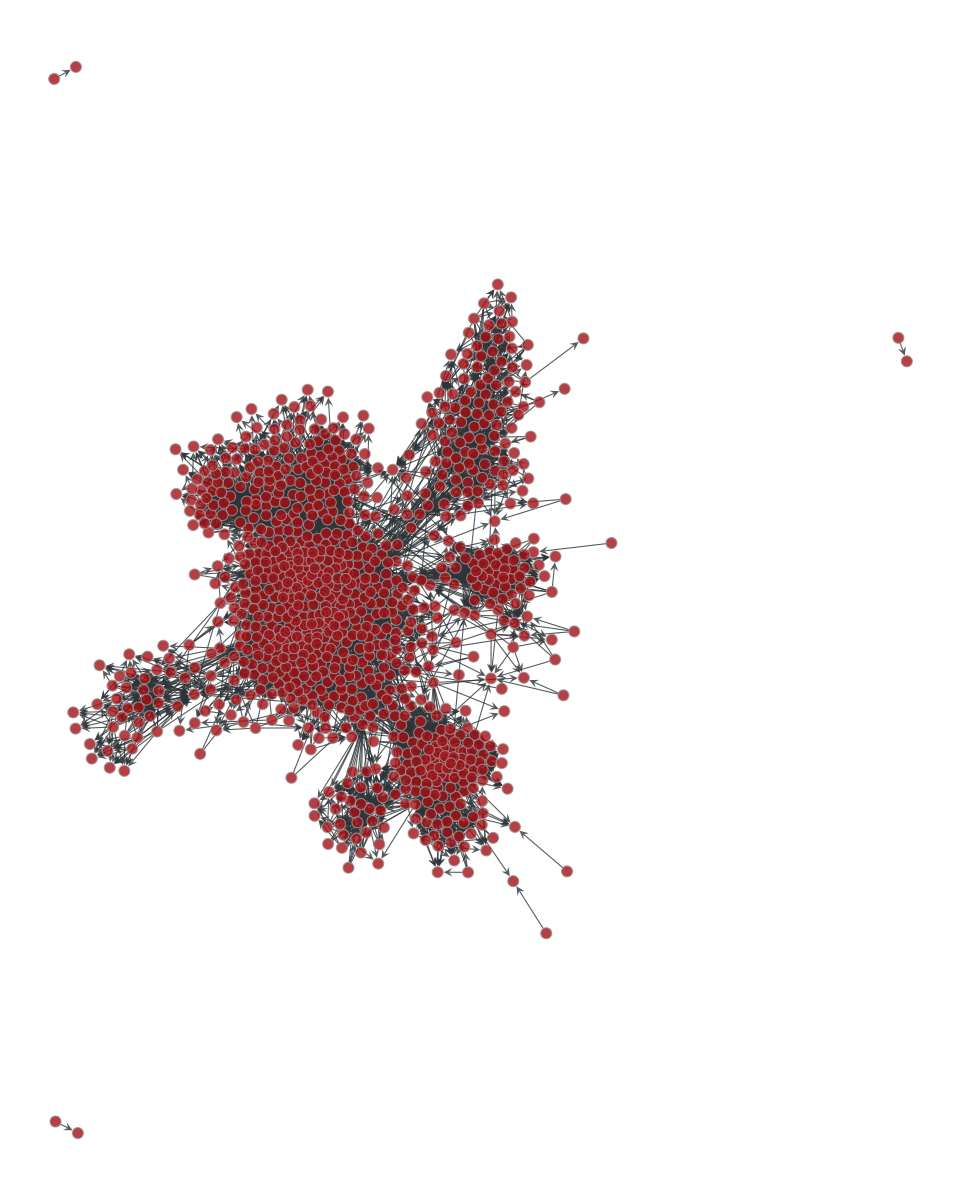

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x427e0e0c0, at 0x4178a09b0>

In [168]:
# draw the graph with the 
pos = sfdp_layout(g)

#Draw the graph with the edge counts
graph_draw(u)


In [169]:
counts

[67868, 69182, 14033, 5492, 695, 757, 381, 337, 26, 1, 2, 18]

Motif 0


Motif 1


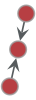

Motif 2


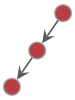

Motif 3


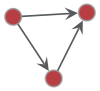

Motif 4


Motif 5


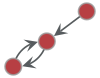

Motif 6


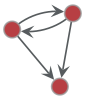

Motif 7


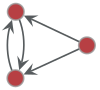

Motif 8


Motif 9


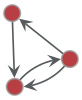

Motif 10


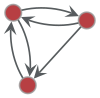

Motif 11


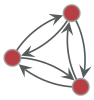

In [170]:
# plot the motifs
#graph_draw(motifs[0], output_size=(50, 50))

# plot all the motifs in rows of 5
for i, motif in enumerate(motifs):
    print("Motif", i)
    graph_draw(motif, output_size=(50, 50))

In [173]:
# plot g with maps[6] vertices highlighted
vertex_property_map = maps[6]
motifs[6]

<Graph object, directed, with 3 vertices and 4 edges, at 0x3ab105250>

In [187]:
motifs6, counts6, maps6 = gt.motifs(u, k=3, p=1.0, motif_list=[motifs[6]], return_maps=True)

In [218]:
# draw map
maps6[0][0]

<VertexPropertyMap object with value type 'int32_t', for Graph 0x47548cda0, at 0x47548c6e0>

In [219]:
graph_draw(maps6[0][0], output_size=(50, 50))

AttributeError: 'VertexPropertyMap' object has no attribute 'num_vertices'

In [220]:
motifs6[0]

<Graph object, directed, with 3 vertices and 4 edges, at 0x47548cda0>